In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [0]:
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

# **Exposition for Multimodal VAE**

**Partners**: Jonathan Chu, Rajath Salegame, Michael Zhang (listed alphabetically)

**Paper citation**: Wu, Mike, and Noah Goodman. "Multimodal generative models for scalable weakly-supervised learning." Advances in Neural Information Processing Systems. 2018.

#### **Notebook Contents**
This notebook contains the exposition of the above paper with relevant thoughts and content tying it to the pedagogical example. 

It is accompanied by another notebook which contains the main working code for the pedagogical example. We separated the two for readability. 



### ***1. Summary of Abstract***

We can think of anything we perceive as a combination of multiple modalities. This also extends to a numerical multivariate probability distribution, where each variable or dimension is a modality. For example, $\mathbf{X} \sim \mathcal{N}(\mathbf{\mu}, \mathbf{\sigma}^2)$, where $\mathbf{\mu} = (\mu_1, \mu_2, \ldots, \mu_n)$, $\mathbf{\sigma^2} = (\sigma_1^2, \sigma_2^2, \ldots, \sigma_n^2)$, and each $(\mu_i, \sigma_i^2)$ describes a Normal distribution that represents a single modality $M_i$. Learning a joint representation of these modalities is often more useful than conditional distributions in providing information about data. However, many previous deep generative models either (1) do not learn the joint distribution or (2) require more computation to handle missing data. The model described in this paper uses a product-of-experts (PoE) model for inference, shares weights across modalities, and has a sub-sampling training method to efficiently learn across mutiple modalities. The benefits of this include no longer needing to train for every combination, and increased robustness to incomplete/partial datasets.


### ***2. Problem Statement***

**Generatively modeling multiple modalities as a joint distribution is extremely useful for inference, but is computationally intensive and is difficult when certain modalities are missing from the dataset.**

**Can we create a deep generative model that (1) models the joint distribution of our modalities properly, (2) is computationally efficient, and (3) is robust to partial/incomplete datasets?**

### ***2. Context/Scope***

Capturing data across multiple modalities (i.e. multimodal data) could enable more richer understanding of a given dataset. That is, the different modalities could offer complementary or converging information about a scene.

Problem is that multimodal data is often partially sparse, i.e. we might have some modalities in abundance, but others are very sparse. Often times we want  to train multimodal VAE (MVAE) to learn generative model for joint distribution, but in the weakly supervised setting where some data modalities may be missing data

In addition, there is also the fact that to handle multiple modalities with some missing data, we'd need an inference network (encoder of the VAE) for each combination of modalities. This would be untractable, e.g. require exponential number of trainable parameters.

Put simply, this paper is an approach to solve this problem by **learning the joint distribution of modalities in an efficient way that allows for good performance even if the given dataset is incomplete with respect to some modalities.**

To illustrate the problem of multiple modalities, we have coded a small demonstration below:


#### ***Toy setup***

Imagine we have this MVN:

$$X \sim \mathcal{N}(\mu = (1, 2), \sigma^2 = (1, 1))$$

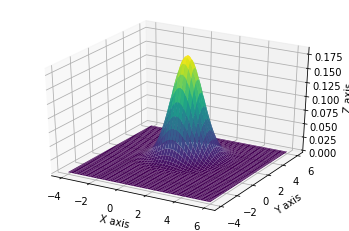

In [0]:
# z_means = np.random.uniform(0, 10, size=2)
# z_vars = np.random.normal(1, 1, size=10)

z_means = range(1, 3)
z_vars = [1, 1]

data = []
for z in zip(z_means, z_vars):
    x = np.random.normal(z[0], z[1], size=100)
    data.append(x)

# print(np.cov(data))

rv = multivariate_normal(z_means, np.cov(data))

# Plot 
x = np.linspace(-4, 6, 100)
y = np.linspace(-4, 6, 100)
X, Y = np.meshgrid(x, y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, rv.pdf(pos),cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

# data_mvn = np.random.multivariate_normal(z_means, np.cov(data), size=100).T

# plt.scatter(x=data_mvn[0], y=data_mvn[1])

Note this is close enough to a multivariate normal with independent modalities:

In [0]:
print('Data Covariance:')
print(np.cov(data))

print('Independent Covariance:')
print(np.identity(2))

Data Covariance:
[[1.17198169 0.0827293 ]
 [0.0827293  1.00128577]]
Independent Covariance:
[[1. 0.]
 [0. 1.]]


Let each dimension be a modality. In which case we would deal with these two observations:

$$X_1 \sim \mathcal{N}(1, 1),\; X_2 \sim \mathcal{N}(2, 1)$$

(For visualization we included them as separate, but in reality we'd need to see the data points together to get the covariance info. With just the modalities, we can't really estimate the joint distribution)


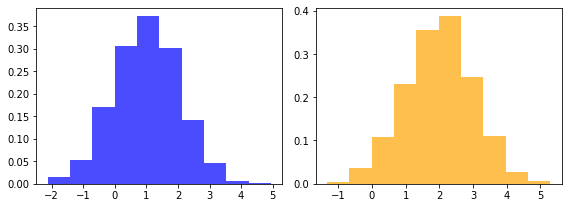

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axes[0].hist(np.random.normal(1, 1, 1000), density=True, color='blue', alpha=0.7)
axes[1].hist(np.random.normal(2, 1, 1000), density=True, color='orange', alpha=0.7)
plt.tight_layout()
plt.show()

Working with simulated data we don't really have to worry about not having enough data in any one modality, and so with enough joint samples we can reconstruct the joint distribution and infer its parameters above, e.g.:

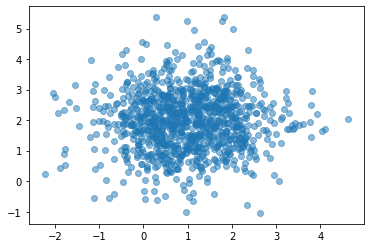

In [0]:
z_means = range(1, 3)
z_vars = [1, 1]

data = []
for z in zip(z_means, z_vars):
    x = np.random.normal(z[0], z[1], size=1000)
    data.append(x)
plt.scatter(data[0], data[1], alpha=0.5)
plt.show()

In the paper's case, we might have a lot of $X_1$, but not that much $X_2$. So separately it could look like: 

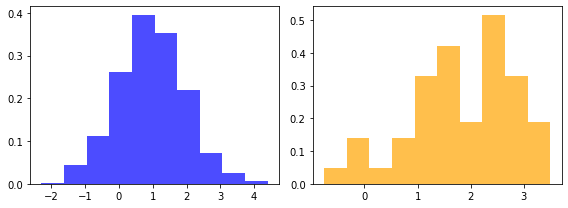

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axes[0].hist(np.random.normal(1, 1, 1000), density=True, color='blue', alpha=0.7)
axes[1].hist(np.random.normal(2, 1, 50), density=True, color='orange', alpha=0.7)
plt.tight_layout()
plt.show()

To show what it'd be like together, recall that our joint distribution is composed of two independent normals basically concatenated together. We can then mask out 950 random samples of $X_2$. 

In reality we wouldn't have any data for the missing data points, so one thing we might imagine doing is using data imputation, replacing them with the average of the $X_2$-dimension of the $50$ samples we do have complete data for. This might not seem like the best thing, but it is one thing we can do:

In [0]:
data = []
for z in zip(z_means, z_vars):
    x = np.random.normal(z[0], z[1], size=1000)
    data.append(x)

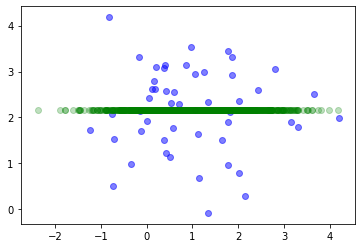

In [0]:
seed = 42
np.random.seed(seed)

saved_ix = np.random.choice(len(data[0]), 50)

data = np.array(data)

observed_data = data.transpose()[saved_ix].transpose()

mean_x2 = np.mean(data[1][saved_ix])

# Probs a better way to do this
unsaved_ix = [ix for ix in range(len(data[0])) if ix not in saved_ix]
imputed_data_x2 = data[1].copy()
imputed_data_x2[unsaved_ix] = mean_x2

imputed_data = np.array([data[0][unsaved_ix], imputed_data_x2[unsaved_ix]])

plt.scatter(observed_data[0], observed_data[1], alpha=0.5, color='blue')
plt.scatter(imputed_data[0], imputed_data[1], alpha=0.25, color='green')
plt.show()


Comparing to what we should have seen: 

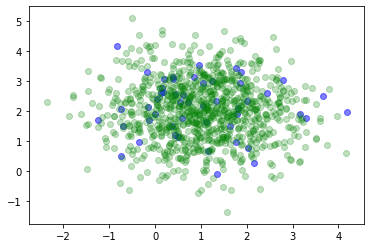

In [0]:
seed = 42
np.random.seed(seed)

saved_ix = np.random.choice(len(data[0]), 50)

data = np.array(data)

observed_data = data.transpose()[saved_ix].transpose()

mean_x2 = np.mean(data[1][saved_ix])

# Probs a better way to do this
unsaved_ix = [ix for ix in range(len(data[0])) if ix not in saved_ix]
imputed_data_x2 = data[1].copy()

imputed_data = np.array([data[0][unsaved_ix], imputed_data_x2[unsaved_ix]])

plt.scatter(observed_data[0], observed_data[1], alpha=0.5, color='blue')
plt.scatter(imputed_data[0], imputed_data[1], alpha=0.25, color='green')
plt.show()


This issue of incomplete/partial datasets with missing information from certain modalities is precisely one of the problems that the paper aims to solve, in an efficient and robust manner.

### ***3. Existing Work***

Previous work in this field has focused primarily on creating generative models given two modalities $x_1$ and $x_2$ of the form $p(x_2\mid x_1)$, such as conditional VAEs (CVAEs) and conditional multi-modal autoencoders (CMMA). However, these models are not bi-directional and do not try to *directly* model the joint distribution, which they empirically find to improve the ability of a model to learn the data distribution.

To this end, some recent models have attempted to directly model the joint distribution of our system. One notable example of this is the joint multi-modal VAE (JMVAE), which trys to learn the joint distribution $p(x_1, x_2)$ using a joint inference network $q(z \mid x_1, x_2)$. However, this model trains a new inference network for each "multi-modal subset" which the authors argue is intractable in a general sense. An extension to this model introduces another objective for the bi-modal VAE, called the triplet ELBO. Like the author's MVAE, this joint inference network joins variational distributions using "Product of Experts". However, because the authors use a two-stage training process and involves two new inference networks, it does not generalize to the multi-mode case efficiently. 


### ***4. Contributions***

The first contribution the authors make is creating a model able to generate and convert between
multiple modalities, doing so in a VAE framework that attempts to model the joint distribution across all modalities. By assuming that the observed modalities are conditionally independent given a shared latent variable, they justify doing this inference through a product-of-experts framework. 

In addition to this, although they are not the first to use VAEs for multimodal learning, the authors argue that in contrast with the previous approaches stated above, the MVAE is the first deep generative model to explore multiple modalities efficiently by a combination of (1) utilizing a single-stage training phase, (2) using a simpler training algorithm via gradient descent, and (3) utilizing a sub-sampling technique to encourage robust (meaning capturing the true marginal distributions) representations in autoencoders.

---

### ***5. Technical content***

There are two main technical features of this paper that allow it to possess the aforementioned differentiators from other models. They are described below at a high level:

***Assumption of conditionally independent modalities***: If we model the modalities as being conditionally independent given some underlying information, then we can use a product-of-experts (PoE) setup, which means we only need to train a single inference network for each modality. This significantly reduces the computational complexity of our network.

***Sub-sampled training paradigm***: To handle joint observations, where some observations might be missing dimensions, they use a sub-sampled training method that treats fully-observed examples as both fully and partially observed.


#### ***5.1 Conditional Independence Assumption for Approximating the Joint Posterior***

A crucial assumption in the paper is that for our multimodal VAE framework, where given observable modalities $X_1, X_2$ that share the latent variable $Z$, that $X_1$ and $X_2$ are conditionally independent given $Z$.

In other words, given $N$ modalities $x_1, \ldots, x_N$, we assume that each modality in subset of modalities $X \subseteq \{x_1, \ldots, x_N\}$, is conditionally independent given the latent variable $z$, i.e. 
$$
p(x_1, \ldots, x_N \mid z) = \prod_{i=1}^N p(x_i \mid z)
$$

This lets us derive the joint posterior as

$$
p(z \mid x_1, \ldots, x_N) \propto \frac{\prod_{i=1}^N p(z \mid x_i)}{\prod_{i=1}^{N - 1}p(z)}
$$

However, alternatively, the authors suggest approximating $p(z \mid x_i)$ with $q(z \mid x_i) = \tilde{q}(z \mid x_i) p(z)$, where $\tilde{q}(z \mid x_i)$ is the underlying inference network in order to avoid the quotient term. This leads to the following form of the joint posterior as:

$$p(z \mid x_1, \ldots, x_N) \propto p(z) \prod_{i=1}^N \tilde{q}(z \mid x_i)$$

Ths product is referred to as the "product of experts" (PoE) (including a prior expert), constituting an approximating distribution for the joint-posterior. This representation is simpler, more numerically stable, and more generalizable to multiple modalities. Thus, this representation of the joint posterior is what is referred to as MVAE in the paper.

***Extension: Testing the assumption (in pedagogical example)***

With our toy setup then we can test the robustness of this assumption with three data simulations:  
1. Simulate multivariate data that actually is conditionally independent. Let $Z \sim \mathcal{N}(\mu, \sigma^2)$, then 
$$
X_1 = aZ + Z_1,\;Z_1 \sim \mathcal{N}(\mu_1, \sigma_1^2)
$$ 
$$
X_2 = bZ + Z_2,\;Z_2 \sim \mathcal{N}(\mu_2, \sigma_2^2)
$$
$$
X = (X_1, X_2)
$$ 

2. Simulate MVN that is unconditionally independent as well, e.g. just concat two independent normals together:
$$
X_1 \sim \mathcal{N}(\mu_1, \sigma_1^2) 
$$ 
$$
X_2 \sim \mathcal{N}(\mu_2, \sigma_2^2) 
$$ 
$$
X = (X_1, X_2)
$$

3. Have data that is conditionally dependent:

$$
X_1 = aZ,\; X_2 = bZ
$$
$$
X = (X_1, X_2)
$$ 

With the conditional independence assumption, we can also define a multimodal ELBO (evidence lower bound) as:

$$
\begin{equation}
ELBO(X) = E_{q(z | X)}\Big[\sum_{x_i \in X} \lambda_i \log p_\theta (x_i | z)\Big] - \beta \cdot D_\text{KL}(q(z | X), p(z))
\end{equation}
$$

where $X$ is the set of all present or available modalities.

We can then train our VAE by maximizing this.

#### ***5.2 Sub-sampled Training Paradigm***

One issue with the above ELBO and PoE setup is that the PoE of Gaussians cannot uniquely specify the component Gaussians. So if we have a complete dataset with no missing modalities, we don't train the individual encoders and so if at test time we don't have certain modalities, we can't really use them individually.

If we just assume independences for each modality, then we can train othe inference networks, but then we don't capture relationships between the modalities in our generative model.


Instead, they propose a training scheme that utilizes ELBO terms for both whole and partial observations.  Note that for $N$ modalities, we might imagine trying to train on $2^N$ partial examples, which is just the power set containing all possible combinations of modalities. 

They acknowledge this is intractable, so instead propose a heuristic that hopes to capture good representation across all partial modality possibilities. To decrease computational cost, they interestingly sub-sample which ELBO terms to optimize at each gradient step. 

This involves summing 3 ELBO terms:  
1. ELBO with respect to product of all $N$ Gaussians (the complete dataset, seen above)  
2. The sum of each ELBO over a single modality  

3. The sum of $k$ randomly selected ELBOs over a single modality combination

which is equation 5:

$$
\mathcal{L} = \text{ELBO}(X = X_1, \ldots, X_n) + \sum_{i=1}^n\text{ELBO}(X_i) + \sum_{j=1}^k\text{ELBO}(P(X)_j)
$$

where $P(X)$ denotes the power set and $|P(X)| = 2^N$.

With this method, they are able to sample partial data from $X$, even though certain modalities may be missing!

### ***6. Experiments***

The experiments performed to validate MVAE involve comparing performance of existing models like VAE, BiVCCA, and JMVAE to MVAE on four image datasets: MNIST, FashionMNIST, MultiMNIST, and CelebA. Consistent with previous literature, they transform a unimodal problem into a multimodal one by making the image label the second mode. For all experiments, architectures were consistent, with only the loss function and training method varied.

Let $x_1$ denote the image and $x_2$ the label. The authors compare the models against each other by (1) measuring the test marginal log-likelihood $\log p(x_1)$ and test joint log-likelihood $\log p(x_1, x_2)$ over $z$. Essentially, the authors claim that the marginal probabilities capture the model's ability to replicate the joint and conditional distributions. 

They also tested varying the hyperparameter $k$, which controls the number of ELBO terms to approximate the objective. In addition, the authors simulated incomplete supervision (weakly supervised learning) by randomly making a fraction of the dataset multimodal. 



Below are a few of the important/interesting findings in these experiments:

* MVAE and JMVAE are approximately the same in data log-likelihood but MVAE uses fewer parameters
* CVAE is better at capturing $p(x_1 \mid x_2)$ but does not learn the joint 
* If considering only $\log p(x_1)$, MVAE performs best
* PoE approach appears to generalize to large number of modalities
*  Increasing $k$ has only little effect on data log likelihood but decreases variance of importance distribution defined by inferential network 
* MVAE beats all models in a "medium-supervised" regime; that is, there are enough labeled samples to sufficiently train but not to learn a fully supervised network


Finally, the authors use this generative model in two case studies--computer vision and machine translation--to demonstrate that this model has practical utility as well.

The authors demonstrate through these experiments and case studies that indeed, by constructing a multi-modal variational autoencoder that learns a joint distribution and is robust to missing data, the MVAE matches state-of-the-art performance in experiments and has potential to achieve high performance in the real world as well. 

### ***7. Evaluation***

Simply put, the authors' theoretical work is accurate and sound. The derivation of the Product of Experts follows concisely from the independence assumption, only requiring a few applications of Bayes' Rule. The sub-sampled training paradigm is theoretically intuitive and the loss function straightforward to construct.

Experimentally, the authors support their work thoroughly with many different models and datasets. They show that the proposed model is consistently able to learn a joint distribution across modalities while producing individual inference networks that are on par with uni-modal architectures. 

A general critique, however, is on the scope of the demonstrated modalities in the test settings. Out of all the datasets tested on, only one consisted of more than 2 modalities (CelebA). Moreover, the modalities considered using CelebA are simply binary attributes-turned-modalities. How do the techniques fare in settings with distinctive modalities each with more thorough supports and data distributions? Additionally, the authors test values of $k$ within the sub-sampled training paradigm, but their conclusion that a smaller $k$ is preferred due to the tradeoff between training time and a higher-certainty importance distribution is only validated by tests using the limited CelebA dataset. For more discussion on modality and our own analysis of their model see our pedagogical example and specificlly the last section: "Future work: What counts as a modality?" (pedagogical_example-mvae.ipynb). They do include case studies on two real world applications with greater than $2$ modalities: computer vision applications where each modality takes the form of a popular image transformation, and machine translation where modalities are different languages. These are definitely interesting applications of their model, and further work could elucidate how practical the MVAE and joint learning of multimodal data are regarding real world applications. 

Overall, the authors' proposed PoE model is theoretically and empirically well supported, and the sub-sampling heuristic's efficacy is likewise validated by their empirical results. More experiments with greater than 2 modalities could further justify their claim that the MVAE is practical to use and tractably scales with more modalities, and further discussion and experiments on additional modalities could also yield empirical analysis into the limits of their model with regard to what counts as a modality. We include specific points of critique that we found could be the starting point of future work in the next section, which is replicated in our pedagogical example notebook.


### ***8. Discussion and Future Work***

Note: this section has been duplicated from pedagogical_example-mvae.ipynb for continuity.

Through our pedagogical example of numerical distributions, we were able to illustrate three possible modality scenarios and the MVAE's respective performance. Perhaps unsurprisingly, the model did best when the data was explicitly generated under a more helpful stronger assumption. Performance decreased when data was generated to fit the MVAE's conditional dependence assumption across modalities allowing the product-of-experts formuation and finally did worst in the setting where the assumption was false.. 

We now further consider instances in the paper that could be expanded upon or improved on, suggesting follow-on work.

#### ***1. Scalable multimodal learning***

While the authors claim that their method is able to efficiently and effectively learn joint distributions across multiple modalities, in their provided experiments they only evaluate with one real setup using the CelebA dataset (MVAE19), where images are still one modality but 19 attributes describing the various images are each treated as a separate modality. While success on CelebA may suggest success on MNIST, further experiments working with more than 2 modalities would have been nice to illustrate the robustness of the model, especially because the contribution of being able to tractably learn the joint distribution of multiple modalities without having to train on every combination was so emphasized in the introduction and with respect to previous multimodal generative models.

#### ***2. Sub-sampling heuristic***

With regard to dealing with more than two modalities and model robustness in the form of missing modalities, the authors propose a sub-sampling method that while reasonable, is also a heuristic. Motivated by the ELBO, they calculate the model's ELBO on a subset of randomly selected combinations, and optimize this jointly with the ELBO over all available modalities and each single modality. This method is subject to the number of combinations used during training (denoted by $k$ in the paper). They do include a result varying $k$ from $0$ to $50$ and show how model performance increases with higher $k$ (which is an intuitive result as well so we did not include this in our pedagogical example), but it leaves an open question if the simple method can be improved. Does it make sense to just sample combinations uniform randomly? Perhaps some combinations of modalities are more prominent than others, and so a weighted distribution might make the model more practical with respect to down-stream weakly supervised learning.

#### ***3. What counts as a modality?***

In relation to the above, the modalities were limited to text and images. While practically, these two modalities may be sufficient as computer vision and NLP are both rather mature and much real world understanding comes through these two modalities, it would have been nice to consider the semantics of what counts as a modality, and perhaps motivate more experiments with more modalities. The case study of computer vision, where given an underlying image, each modality is a transformation used in common image processing tasks (e.g. showing only the edges for edge detection, or blocking half the image for partial reconstruction) was an interesting example of expanding the modalities available. That being said, image and text remain natural and obvious choices, and although this was less the authors and more a field paradigm, it is still cool how treating the labels as a text modality can enable weakly-supervised learning when trying to do multi-modal learning with modal imbalance.

#### ***4. Learnable modality influence***

Finally as noted earlier, one prominent component that was missing from the paper was the generalized product of experts (gPoE), which aims to identify which modalities are more reliable or important at learning the joint distribution. Accordingly, instead of 

$$
P(y \mid x) = \frac{1}{N}\prod_{i}p_i(y \mid x), \text{ where }p_i(y \mid x) = \mathcal{N}(m_i(x), \Sigma_i(x))
$$

in the supervised setting for $N$ experts, with the product given as
$$
P(y \mid x) \sim \mathcal{N}(m(x), \Sigma(x))
$$
where
$$
m(x) = \Big(\sum_{i}^N m_i(x) T_i(x)\Big) \cdot \Big(\sum_i T_i(x)\Big)^{-1}
\text{ and }
\Sigma(x) = \Big(\sum_{i}^N T_i(x)\Big)^{-1}
$$
and $T_i(x) = \Sigma_i^{-1}(x)$, as in Cao et al. we would have

$$
P(y \mid x) = \frac{1}{N}\prod_{i}p_i^{a_i}(y \mid x)
$$

where $a_i(x)$ can be learned as a weighting for how reliable the $i$-th expert is at datapoint $x$. With the Gaussian assumptions, we could then implement this with

$$
m(x) = \Big(\sum_{i}^N m_i(x) a_i(x) T_i(x)\Big) \cdot \Big(\sum_i a_i(x) T_i(x)\Big)^{-1}
$$
$$
\Sigma(x) = \Big(\sum_{i}^N a_i(x) T_i(x)\Big)^{-1}
$$



As observed in our pedagogical example, certain modalities are more representative of the larger set of modalities than others, and so could be given more weight in the PoE framework for estimation. This could also motivate ideas related to active learning that choose which sub-sampled combinations of modalities should be selected for training.